# Pythonopdracht - Programming for Data Science - Jelle van Barneveld

## Installatie- en gebruiksinstructies

In [ ]:
pip install -r requirements.txt

<b>Deze code hoef je alleen te runnen bij de allereerste keer dat je dit Notebook runt</b>.
Het zorgt ervoor dat de juiste (versies van) packages geïnstalleerd worden, alvorens de packages daadwerkelijk geïmporteerd worden.

Om de rest van dit notebook succesvol te kunnen runnen dien je de volgende stappen te ondernemen. Hierbij gaat men ervan uit dat het script geraadpleegd wordt door een Windows-apparaat.
- Open Google Chrome en klik op de drie puntjes bovenaan. Ga via "Help" naar "Over Google Chrome". Je ziet een versienummer, onthoud de cijfers t/m de eerste punt.
- Ga naar https://chromedriver.chromium.org/downloads en klik op het onthouden versienummer. Kies voor de Windowsversie, download de zipmap en pak deze uit. Verplaats de applicatie "chromedriver" naar C:\Program Files (x86)

Als het goed is runnen na het doorlopen van deze stappen de onderstaande 2 codeblokken succesvol. Zij vormen dus een goede test om te kijken of de installatiestappen goed zijn uitgevoerd, en bevatten tegelijkertijd benodigdheden om de rest van de code te kunnen runnen.

Twee laatste kleine aandachtspunten bij het doorlopen van dit script:
- Er zal je eenmalig via een prompt om een getal gevraagd worden. Vergeet deze niet in te voeren, anders loopt het script niet door.
- Zorg er altijd voor dat je een actieve internetverbinding hebt gedurende de tijd dat het script doorloopt.

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchWindowException
from bokeh.plotting import figure, show
from bokeh.models import LogColorMapper, ColumnDataSource
from bokeh.palettes import RdYlGn as correct_palette

import pandas as pd
import requests
import warnings
import logging
import numpy as np
import datetime
import geopandas
import matplotlib.pyplot as plt

In [3]:
pad = "C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(pad)
warnings.simplefilter(action = 'ignore', category = FutureWarning)

C:\Users\chris\AppData\Local\Temp\ipykernel_18424\2948619622.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(pad)


## Fase 1: Business Understanding

### 1a: Aanleiding

Iedere zomer ga ik met ongeveer zeven a acht vrienden op vakantie in Nederland, we huren dan altijd een huisje. Op internet zoeken we een aantal maanden voor de schoolvakantie een huisje dat ons hiervoor geschikt lijkt. Elk van ons controleert deze geschiktheid volgens andere eisen. Grofweg kunnen deze in 2 categorieën worden opgedeeld:
- Eisen aan het huisje zelf: denk aan aantallen slaapkamers, WiFi-mogelijkheden, enzovoort. Deze informatie wordt aangeboden door de website natuurhuisje.nl.
- Eisen aan de omgeving van het huisje: dit omvat de aanwezigheid van een supermarkt en verschillende activiteiten, bijvoorbeeld pretparken, zwembaden, klimbossen, enzovoort. Deze informatie halen we voor het grootste gedeelte uit Google Maps.

Het zoekproces om een huisje te vinden dat aan alle eisen voldoet is tijdrovend: gemiddeld doen we er twee weken over om te beslissen wat het meest geschikte huisje is. Dit wordt met name veroorzaakt door het feit dat we niet weten wat binnen Nederland het meest aantrekkelijke zoekgebied is: om provinciale verschillen te achterhalen moeten we, zoals eerder vermeld, meerdere websites raadplegen. In dit beslisproces moeten we dus continu switchen tussen huisjes- en uitjesinformatie per provincie en daarbij zeer alert zijn op alle voorwaarden die we hebben gesteld.

### 1b: Het onderzoek: hoofd- en deelvragen

Dit script is geschreven om (de hiaten in de) bovengenoemde situatie te verbeteren door het beantwoorden van de volgende hoofdvraag: <b>"In welke provincie kan je het beste een huisje huren?"</b>. Hierdoor krijgen we snel inzicht in zowel de huisjes- als omgevingsverschillen per provincie, zodat we het "zoekgebied" kleiner kunnen maken ter verkleining van de zoektijd.

Om ervoor te zorgen dat het antwoord van deze vraag volledig volgens meerdere criteria beantwoord wordt, is deze opgesplitst in 4 deelvragen:
- In welke provincie staan de meeste huisjes?
- In welke provincie staan de huisjes met de laagste gemiddelde afstand tot een supermarkt?
- In welke provincie staan de huisjes met de laagste gemiddelde afstand tot een zwembad?
- In welke provincie staan de huisjes met de laagste gemiddelde afstand tot een attractie?

Voor de eerste deelvraag wordt de hypothese gesteld dat het antwoord "Noord-Holland" is, aangezien deze op nr. 1 staat in de ranglijst grootste Nederlandse provincies (zie ook https://machtig.nl/grootste-provincie-van-nederland-oppervlakte-inwoners/, laatst geraadpleegd op 27-06-2023). Hierbij wordt dus de aanname gedaan dat de grootte van de provincie correleert met het aantal huisjes dat daar staat.

Voor de andere drie deelvragen wordt de hypothese gesteld dat het antwoord "Zuid-Holland" is, aangezien dit de meest "levendige" provincies zijn (ze hebben de grootste Nederlandse steden, zijn het beste bereikbaar, enzovoort). Hierbij wordt er dus vanuit gegaan dat de levendigheid van een provincie uitmaakt voor de afstanden tot voorzieningen, uitgaansgelegenheden, attracties en andersoortige uitjes.

### 1c: Doelstelling

Met het geschreven script wil men het bovengenoemde zoek- en beslisproces om een huisje te vinden dat aan alle voorwaarden voldoet met de helft (een week) te verminderen. Doordat provinciale verschillen snel zichtbaar worden door een allesomvattende dataset, en er dus niet meer geschakeld hoeft te worden tussen verschillende websites, kunnen er naar verwachting sneller huisjes gevonden en gekeurd worden.

### 1d: Fasering & aanpak

Voor het grootste gedeelte van deze opdracht zijn de stappen van het veelgebruikte CRISP-DM-procesmodel (Cross-industry Stand Process for Data Mining): op een "watervalwijze" doorlopen. Dit houdt in dat per projectfase een CRISP-DM-fase werd uitgevoerd. In het onderstaande plaatje wordt dit visueel weergegeven: in de eerste fase wordt bijvoorbeeld alles gedaan van Business Understanding, in de tweede fase alle activiteiten die bij Data Understanding horen, enzovoort.

<img src="CRISP DM Waterval.PNG" alt="CRISP DM Waterval" />

Bij de afweging tussen de watervalaanpak en een Agile-aanpak is er volgens de richtlijnen van de Ralph-Staceymatrix (zie hieronder) uiteindelijk voor deze eerste gekozen om twee redenen:
- De gebruikte technieken waren van tevoren al bekend (namelijk Python-only) en ook zij zijn niet veranderd in de loop der tijd. Weliswaar moest men een aantal onbekende Python-packages gebruiken (selenium, bokeh, enzovoort), maar hier was voldoende informatie over te vinden op het internet. In de Ralph-Staceymatrix positioneerde dit project zich dus links op de horizontale as.
- De tijdens "Business Understanding" geïnventariseerde eisen bleven gedurende dit hele traject ongewijzigd. In de Ralph-Staceymatrix positioneerde dit project zich dus laag op de verticale as.

<img src="Ralph Stacey.png" alt="Ralph-staceymatrix" />

Hieronder volgt per CRISP-DM-stap een globale beschrijving van de toepassingswijze binnen de projectfasen:
- <b>Fase 1: Business Understanding:</b> er is een aanleiding, opdracht en doelstelling geformuleerd, waarmee men de toegevoegde waarde van dit project rechtvaardigt.
- <b>Fase 2: Data Understanding:</b> in deze tweede fase is er data gelokaliseerd d.m.v. het verzamelen van handige databronnen (een website, een API & een gedownload geojson-bestand) die elk veel informatie bevatten. Wat de website (natuurhuisje.nl) betreft zijn d.m.v. de "Inspecteren"-optie van Google Chrome de relevante achterliggende HTML-structuren geanalyseerd, om vast te stellen naar welke elementen Python moet zoeken voor het verkrijgen van de juiste informatie.
- <b>Fase 3: Data Preparation:</b> hier wordt de relevante geïnventariseerde data daadwerkelijk opgehaald en in een dataset gezet. Het bewaken van de volledigheid en integriteit van de data staat hierbij centraal: continu wordt de uiteindelijke dataset in Visual Studio Code vergeleken met bijvoorbeeld webpagina's in Chrome om vast te stellen of álle en de júiste data goed overgekomen zijn.
- <b>Fase 4: Evaluation & Deployment:</b> hier worden in o.a. een interactieve kaart visuele analysetechnieken gecombineerd om de betreffende deelvragen, en daarmee de hoofdvraag, te beantwoorden. Hierbij wordt zoveel mogelijk geprobeerd om de gestelde hypotheses te ontkrachten: je mag er immers pas vanuit gaan dat iets waar is, als je het tegendeel niet meer kan bewijzen. De gemaakte kaart wordt gepresenteerd in een HTML-bestand dat de gebruiker naar eigen inzicht kan raadplegen.

De CRISP-DM-fase "Modelling" is in dit project buiten beschouwing gelaten, omdat er geen Machine-Learningtechnieken zijn toegepast.

## Fase 2: Data Understanding

### 2a: De natuurhuisjes op zich

In [4]:
while(True):
    
    try:
        aantal_resultaten_per_pagina = 20 #Deze staat vast op natuurhuisje.nl
        geschat_aantal_minuten_per_pagina = 0.25
        aantal_paginas = int(input("Hoeveel pagina's wil je inlezen? Elke pagina bevat " + str(aantal_resultaten_per_pagina) + " huisjes en duurt ongeveer " + str(geschat_aantal_minuten_per_pagina) + " minuten om in te lezen"))
        
        totaal_aantal_huisjes = aantal_paginas * aantal_resultaten_per_pagina
        geschatte_tijdsduur_totaal = aantal_paginas * geschat_aantal_minuten_per_pagina

        print("Er zullen " + str(aantal_paginas) + " pagina's ingelezen worden, wat resulteert in " + str(totaal_aantal_huisjes) + " in de dataset. Dit zal ongeveer " + str(geschatte_tijdsduur_totaal) + " minuten kosten.")
        print("Wil je het laadproces tussentijds afbreken? Sluit de Chrome Webviewer, die zichzelf opent aan het begin van het laadproces, dan af.")
        
        break
    except ValueError:
        print("Voer een geheel getal in!")

Er zullen 3 pagina's ingelezen worden, wat resulteert in 60 in de dataset. Dit zal ongeveer 0.75 minuten kosten.
Wil je het laadproces tussentijds afbreken? Sluit de Chrome Webviewer, die zichzelf opent aan het begin van het laadproces, dan af.


De gebruiker wordt gevraagd een aantal webpagina's in te vullen om in te lezen: elke pagina bevat 20 huisjes om toe te voegen aan de dataset. Als de gebruiker iets anders dan een getal invult krijgt hij/zij een boodschap dat er toch echt een <b>geheel getal</b> ingevoerd moet worden. Zolang de gebruiker dit niet doet gaat het programma niet verder, als de input dan uiteindelijk <b>wel</b>klopt worden de volgende codeblokken uitgevoerd.

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

file_handler = logging.FileHandler('logs.txt', mode = 'w')
file_handler.setLevel(logging.DEBUG)

logger.addHandler(file_handler)

Bij het inlaadproces is het de bedoeling dat er logs worden gegenereerd en weggeschreven naar een bestand, dat door dit Notebook zelf aangemaakt wordt ('logs.txt'). De bovenstaande code initialiseert deze logger.

In [6]:
aantal_verwerkte_huisjes = 0
df_lijst = []

Tijdens het doorlopen van het laadproces zal het aantal verwerkte huisjes bijgehouden en na elk huisje geüpdate worden. Daarom wordt deze nu alvast geïnitaliseerd. Ditzelfde geldt voor de lijst met dataframes die tijdens het laadproces gevuld zal worden (één dataframe per doorlopen pagina met zoekresultaten).

In [7]:
def maak_detailpagina_frame(link):
    url = requests.get(link)
    df = pd.concat([pd.read_html(url.text)[0], pd.read_html(url.text)[1]], axis = 0)
    
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    
    return df

Deze functie wordt aangeroepen per huisjespagina met detailinformatie. Stel dat de parameter "link" de volgende URL als waarde heeft: https://www.natuurhuisje.nl/vakantiehuisje/60401 . Als je op deze URL klikt zie je dat er 2 tabellen zijn die allebei relevante eigenschappen bevatten om in de uiteindelijke dataset op te nemen. Beide tabellen worden ingelezen en in eerste instantie gebeurt dat "row-wise": elke huiseigenschap krijgt zijn eigen rij (met in de eerste kolom de betreffende eigenschap en in de tweede kolom diens bijbehorende waarde). Met de onderste coderegels worden deze eigenschappen naar de kolommen verplaatst, waardoor je in het dataframe slechts 1 regel overhoudt, en wordt het dataframe geretourneerd.

In [8]:
def haal_woonplaatsen_uit_resultatenlijst(html_brij):
    alle_woonplaatsen = []

    for html_element in html_brij:
        opgesplitste_html_elementen = html_element.text.split("\n")
        woonplaats_list = [s for s in opgesplitste_html_elementen if "Natuurhuisje in" in s]
        woonplaats_str = woonplaats_list[0]
        alle_woonplaatsen.append(woonplaats_str)
    
    return alle_woonplaatsen

Deze functie wordt aangeroepen per pagina met zoekresultaten. Aan deze functie wordt de parameter "html_brij" weergegeven: dit is HTML-code die verantwoordelijk is voor het correct weergeven van de huisjes op een bepaalde pagina met zoekresultaten (zie https://www.natuurhuisje.nl/vakantiehuizen/nederland?skip=0 voor een voorbeeld). Op het moment dat deze functie wordt aangeroepen is de "brij" al gefilterd: alleen de HTML-code die betrekking heeft op de huisjes zit hierin. Alle andere code (head, footer, meta, enzovoort) wordt buiten beschouwing gelaten.

In de for-loop wordt elk huisje doorlopen: diens elementen worden per huisje eerst in een lijst gezet. Vervolgens wordt het element gekozen dat de substring "Natuurhuisje in" bevat, omdat daar altijd de woonplaats in staat. Al deze woonplaatsen worden ten slotte toegevoegd aan een allesomvattende lijst, die wordt teruggegeven. Deze functie wordt dus aangeroepen per zoekresultaatpagina, zodat er per pagina dus een lijst ontstaat met correcte betreffende woonplaatsen.

In [9]:
def verzamel_huiselementen(driver, zoekmethode, zoekterm):
    html_brij = driver.find_elements(zoekmethode, zoekterm)
    alle_woonplaatsen = haal_woonplaatsen_uit_resultatenlijst(html_brij)
    df_lijst = []
    
    for i, huidige_woonplaats in enumerate(alle_woonplaatsen):
        huidig_webelement = html_brij[i] 
        
        homepage_df = pd.DataFrame(columns = ['Natuurhuisje-ID', 'Woonplaats'])
        huidig_id = huidig_webelement.get_attribute('data-house-id')
        homepage_df.loc[len(homepage_df)] = [huidig_id, huidige_woonplaats]

        huidige_link = 'https://www.natuurhuisje.nl/vakantiehuisje/' + str(huidig_id)
        detailpagina_df = maak_detailpagina_frame(huidige_link)

        home_en_detailpagina_df = pd.merge(homepage_df, detailpagina_df, on = 'Natuurhuisje-ID', how = 'inner')
        df_lijst.append(home_en_detailpagina_df)
        
    return df_lijst

Ook deze functie wordt, net als de vorige, aangeroepen per pagina met zoekresultaten op de website natuurhuisje.nl (referentie: https://www.natuurhuisje.nl/vakantiehuizen/nederland?skip=0). Eerst wordt de html_brij gedefinieerd en ook meteen gefilterd op zichtbare huisjes met de ingegeven zoekmethode & zoekterm (met find_elements(...)). Ook worden eerst alle woonplaatsen op deze webpagina opgehaald met haal_woonplaatsen_uit_resultatenlijst(...) en in een lijst gezet.

In [10]:
while(aantal_verwerkte_huisjes < totaal_aantal_huisjes):
    
    try:
        url = "https://www.natuurhuisje.nl/vakantiehuizen/nederland?skip=" + str(aantal_verwerkte_huisjes)
        driver.get(url)
    
        alle_zoekresultaten = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'search__result-list')))   
        alle_huisjes_op_een_pagina = verzamel_huiselementen(driver, 'xpath', "//article[@class ='card card--horizontal card--house-search']")
        df_lijst += alle_huisjes_op_een_pagina
        
        aantal_verwerkte_huisjes += 20
        print(str(aantal_verwerkte_huisjes / 20) + " pagina's verwerkt")
        logger.info(url + " succesvol verwerkt")

    except NoSuchWindowException:
        logger.error("WEBDRIVER GESLOTEN bij " + url + ". Resultaten van deze pagina zijn niet verwerkt")
        break

df_lijst

1.0 pagina's verwerkt
2.0 pagina's verwerkt
3.0 pagina's verwerkt


[  Natuurhuisje-ID               Woonplaats      Regio       Land  \
 0           71654  Natuurhuisje in Jubbega  Friesland  Nederland   
 
   Aantal personen          Type Huursituatie       Ligging       Check-in  \
 0               6  Vakantiehuis   Vrijstaand  Alleenstaand  15:00 - 22:00   
 
        Check-out  
 0  07:00 - 11:00  ,
   Natuurhuisje-ID               Woonplaats    Regio       Land  \
 0           71483  Natuurhuisje in IJhorst  Drenthe  Nederland   
 
   Aantal personen Slaapkamers          Type Huursituatie  \
 0               6           3  Vakantiehuis   Vrijstaand   
 
                      Ligging       Check-in      Check-out  
 0  Kleinschalig vakantiepark  15:00 - 20:00  07:00 - 11:00  ,
   Natuurhuisje-ID                Woonplaats      Regio       Land  \
 0           71523  Natuurhuisje in Hommerts  Friesland  Nederland   
 
   Aantal personen Slaapkamers        Type Huursituatie  \
 0               4           2  Safaritent   Vrijstaand   
 
              

Voor het verzamelen van data over de natuurhuisjes van de website natuurhuisje.nl wordt dit codeblok uitgevoerd. Deze doorloopt de resultatenlijst van de URL https://www.natuurhuisje.nl/vakantiehuizen/nederland , die verspreid is over meerdere pagina's met zoekresultaten. Per pagina wordt een grote hoeveelheid HTML-code opgehaald, waarmee vervolgens de functie verzamel_huiselementen(...) aangeroepen wordt. Deze maakt gebruik van 2 aanvullende voorgedefinieerde functies (voor detailinfo: scroll terug naar boven): 
- haal_woonplaatsen_uit_resultatenlijst(...): deze heeft betrekking op de betreffende pagina met zoekresultaten. Hieruit wordt het ID en de woonplaats van elk huisje geëxtraheerd en in een Pythonlijst gezet.
- maak_detailpagina_frame(): deze heeft betrekking op pagina's met detailinformatie. Vanuit de pagina met zoekresultaten wordt naar elk huisje "doorgeklikt". Deze wordt gebundeld in een dataframe, welke ten slotte wordt teruggegeven.

De outputs van deze 2 functies wordt, nog steeds in de functie verzamel_huiselementen(...), gecombineerd en geretourneerd als dataframelijst ("alle_huisjes_op_een_pagina"), welke toegevoegd wordt aan de overkoepelende dataframelijst ("df_list"). Vervolgens wordt het bericht dat de betreffende pagina met zoekresultaten succesvol is verwerkt gelogd (naar het eerder aangemaakt 'logs.txt'), waarna er een nieuwe URL gegenereerd wordt die de volgende pagina met zoekresultaten aanduidt. De while-loop stopt pas zodra het door de gebruiker ingevoerde aantal pagina's is verwerkt.

De gebruiker kan tussentijds de reeds automatisch geopende Chrome Webviewer sluiten om het laadproces voortijdig af te breken. Dan treedt er een "NoSuchWindowException" op, maar de except-clausule in de bovenstaande code zorgt ervoor dat de reeds verzamelde data in zo'n geval niet zomaar wordt weggegooid.

In [11]:
file_handler.close()
huisjes = pd.concat(df_lijst, ignore_index = True)
huisjes

,Natuurhuisje-ID,Woonplaats,Regio,Land,Aantal personen,Type,Huursituatie,Ligging,Check-in,Check-out,Slaapkamers
0,71654,Natuurhuisje in Jubbega,Friesland,Nederland,6,Vakantiehuis,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,NaN
1,71483,Natuurhuisje in IJhorst,Drenthe,Nederland,6,Vakantiehuis,Vrijstaand,Kleinschalig vakantiepark,15:00 - 20:00,07:00 - 11:00,3
2,71523,Natuurhuisje in Hommerts,Friesland,Nederland,4,Safaritent,Vrijstaand,Kleinschalig vakantiepark,15:00 - 22:00,07:00 - 10:00,2
3,71464,Natuurhuisje in Stegeren,Overijssel,Nederland,5,Bungalow,Vrijstaand,Kleinschalig vakantiepark,15:00 - 23:00,07:00 - 11:00,3
4,71465,Natuurhuisje in Tjerkwerd,Friesland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 22:00,07:00 - 11:00,3
5,71467,Natuurhuisje in Mariënberg,Overijssel,Nederland,6,Vakantiehuis,Vrijstaand,In een dorpje,15:00 - 20:00,07:00 - 10:00,4
6,71679,Natuurhuisje in Groningen,Groningen,Nederland,3,Tiny house,Vrijstaand,Op een erf,15:00 - 20:00,07:00 - 11:00,1
7,71499,Natuurhuisje in Putten,Gelderland,Nederland,6,Glamping,Vrijstaand,Op een landgoed,16:00 - 21:00,08:00 - 11:00,2
8,71553,"Natuurhuisje in Zeeland, Maashorst",Noord-Brabant,Nederland,2,Pipowagen,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,1
9,71468,Natuurhuisje in Callantsoog,Noord-Holland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 23:00,09:00 - 11:00,2


Deze code sluit allereerst de file_handler, om te voorkomen dat de logs van twee verschillende keren dat dit Notebook wordt gerund in hetzelfde bestand terechtkomen. Je wilt namelijk alleen de berichten lezen die betrekking hebben op de meest recente run, zonder een heel groot bestand door te hoeven scrollen. Vervolgens worden alle dataframes van alle pagina's met zoekresultaten samengevoegd tot één groot dataframe ("huisjes").

### 2b: Supermarkten en uitjes

In [12]:
# def get_odata(target_url):
#     data = pd.DataFrame()
#     while target_url:
#         r = requests.get(target_url).json()
#         data = data.append(pd.DataFrame(r['value']))

#         if '@odata.nextLink' in r:
#             target_url = r['@odata.nextLink']
#         else:
#             target_url = None
            
#     return data

def get_odata(target_url):
    data = pd.DataFrame()
    while target_url:
        r = requests.get(target_url).json()
        data = pd.concat([data, pd.DataFrame(r['value'])])

        if '@odata.nextLink' in r:
            target_url = r['@odata.nextLink']
        else:
            target_url = None
            
    return data

De bovenstaande functie laadt data vanuit CBS Statline in, in een dataframe. Hij is gekopieerd en geplakt vanaf https://www.cbs.nl/nl-nl/onze-diensten/open-data/statline-als-open-data/snelstartgids-odata-v4 (laatst geraadpleegd op 27-06-2023). Hieronder volgt een citaat die uitgeeft welke stappen worde doorlopen:

"Een antwoord van een data-verzoek bevat maximaal 100 000 cellen, dus om een grotere dataset te downloaden moeten er meerdere verzoeken aan de API worden gedaan. Wanneer een dataset automatisch wordt afgekapt na het maximale aantal cellen wordt de link naar het volgende deel van de dataset meegestuurd in de variabele @odata.nextLink. In de while-lus wordt het downloaden van 100 000 cellen herhaald door het volgen van @odata.nextLink tot alle informatie gedownload is."

In [13]:
voorzieningen = pd.DataFrame()
huidig_jaar = datetime.date.today().year

while(voorzieningen.shape[0] == 0):
    huidig_jaar_str = str(huidig_jaar)

    voorzieningen = get_odata("https://opendata.cbs.nl/ODataApi/odata/80305ned/TypedDataSet")
    voorzieningen = voorzieningen.loc[voorzieningen['Perioden'].str[0:4] == huidig_jaar_str, :]
    huidig_jaar -= 1

voorzieningen

,ID,RegioS,Perioden,AfstandTotHuisartsenpraktijk_1,Binnen1Km_2,Binnen3Km_3,Binnen5Km_4,AfstandTotHuisartsenpost_5,AfstandTotApotheek_6,AfstandTotZiekenhuis_7,...,Binnen5Km_116,Binnen10Km_117,Binnen20Km_118,AfstandTotSauna_119,AfstandTotZonnebank_120,AfstandTotAttractie_121,Binnen10Km_122,Binnen20Km_123,Binnen50Km_124,AfstandTotBrandweerkazerne_125
16,16,NL01,2022JJ00,1.1,1.3,7.8,16.9,NaN,1.3,4.9,...,1.3,2.9,7.2,7.9,4.1,5.3,3.3,9.6,43.9,2.2
33,33,LD01,2022JJ00,1.5,0.9,4.2,7.6,NaN,1.8,8.9,...,0.7,1.0,2.1,12.2,8.9,7.2,1.3,4.0,21.0,2.8
50,50,LD02,2022JJ00,1.2,0.9,4.5,8.5,NaN,1.4,5.3,...,0.6,1.3,3.6,10.3,4.4,6.1,2.0,5.4,33.5,2.3
67,67,LD03,2022JJ00,0.9,1.6,11.1,25.4,NaN,1.1,3.8,...,1.8,4.3,10.9,5.9,3.1,4.6,4.5,13.5,57.6,1.9
84,84,LD04,2022JJ00,1.1,1.0,5.2,10.7,NaN,1.4,5.1,...,0.9,2.0,4.8,8.0,4.0,5.3,2.7,7.7,33.9,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,9383,GM0879,2022JJ00,2.3,0.3,0.7,0.9,NaN,2.3,11.0,...,0.0,0.3,4.0,15.7,3.6,6.6,0.9,5.6,23.5,2.5
9400,9400,GM0301,2022JJ00,0.8,1.1,7.0,11.3,NaN,1.1,2.9,...,1.9,2.0,3.8,3.9,2.2,3.0,1.0,2.0,34.5,2.0
9417,9417,GM1896,2022JJ00,1.0,0.9,1.8,2.9,NaN,1.2,13.5,...,0.0,0.0,3.1,21.2,11.2,13.3,0.0,5.3,34.7,1.3
9434,9434,GM0642,2022JJ00,0.7,1.3,6.3,16.8,NaN,0.9,2.6,...,0.3,2.8,9.9,5.3,1.6,3.7,1.2,10.2,66.7,1.7


Met deze functie wordt van het CBS de dataset "Nabijheid voorzieningen; afstand locatie, regionale cijfers" opgevraagd. Deze geeft per gemeentecode weer wat de gemiddelde afstand is tot voorzieningen (huisartsenpraktijken, attracties, grote supermarkten, enzovoort). De while-loop zorgt ervoor dat altijd de meest actuele data wordt opgevraagd, door eerst te proberen dit met het huidige jaartal te doen, vervolgens met het vorige jaar, enzovoort. Zodra er daadwerkelijk data wordt ingeladen weet Python dat het het meest recente jaartal heeft waarvan daadwerkelijk data beschikbaar is. Deze data wordt ingeladen, waarna de while-loop wordt gestopt.

In [14]:
woonplaatsen = get_odata("https://opendata.cbs.nl/ODataApi/odata/80305ned/RegioS")
woonplaatsen = woonplaatsen.loc[woonplaatsen['Key'].str[0:2] == 'GM', ['Key', 'Title']]
woonplaatsen

,Key,Title
57,GM1680,Aa en Hunze
58,GM0738,Aalburg
59,GM0358,Aalsmeer
60,GM0197,Aalten
61,GM0480,Ter Aar
...,...,...
551,GM0879,Zundert
552,GM0301,Zutphen
553,GM1896,Zwartewaterland
554,GM0642,Zwijndrecht


Ook met deze functie wordt van het CBS de dataset "Nabijheid voorzieningen; afstand locatie, regionale cijfers" opgevraagd, maar nu wordt achterhaald welke gemeentenaam bij welke bovengenoemde gemeentecode hoort.

In [15]:
voorzieningen_en_woonplaatsen = pd.merge(voorzieningen, woonplaatsen, left_on = 'RegioS', right_on = 'Key', how = 'inner')
voorzieningen_en_woonplaatsen

,ID,RegioS,Perioden,AfstandTotHuisartsenpraktijk_1,Binnen1Km_2,Binnen3Km_3,Binnen5Km_4,AfstandTotHuisartsenpost_5,AfstandTotApotheek_6,AfstandTotZiekenhuis_7,...,Binnen20Km_118,AfstandTotSauna_119,AfstandTotZonnebank_120,AfstandTotAttractie_121,Binnen10Km_122,Binnen20Km_123,Binnen50Km_124,AfstandTotBrandweerkazerne_125,Key,Title
0,985,GM1680,2022JJ00,2.4,0.4,0.9,1.6,NaN,2.5,10.8,...,1.8,13.5,10.9,7.1,1.2,5.3,24.8,2.7,GM1680,Aa en Hunze
1,1002,GM0738,2022JJ00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GM0738,Aalburg
2,1019,GM0358,2022JJ00,0.9,1.0,3.3,8.9,NaN,1.0,5.2,...,12.2,4.7,4.0,2.9,3.4,16.2,78.8,2.9,GM0358,Aalsmeer
3,1036,GM0197,2022JJ00,1.5,1.1,2.6,3.2,NaN,1.5,13.7,...,1.2,13.9,4.4,14.2,0.1,1.5,12.7,1.7,GM0197,Aalten
4,1053,GM0480,2022JJ00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GM0480,Ter Aar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,9383,GM0879,2022JJ00,2.3,0.3,0.7,0.9,NaN,2.3,11.0,...,4.0,15.7,3.6,6.6,0.9,5.6,23.5,2.5,GM0879,Zundert
495,9400,GM0301,2022JJ00,0.8,1.1,7.0,11.3,NaN,1.1,2.9,...,3.8,3.9,2.2,3.0,1.0,2.0,34.5,2.0,GM0301,Zutphen
496,9417,GM1896,2022JJ00,1.0,0.9,1.8,2.9,NaN,1.2,13.5,...,3.1,21.2,11.2,13.3,0.0,5.3,34.7,1.3,GM1896,Zwartewaterland
497,9434,GM0642,2022JJ00,0.7,1.3,6.3,16.8,NaN,0.9,2.6,...,9.9,5.3,1.6,3.7,1.2,10.2,66.7,1.7,GM0642,Zwijndrecht


De gemeentecodes van voorzieningen en gemeentenamen van woonplaatsen worden hier horizontaal samengevoegd.

### 2c: Provincies

In [16]:
provincies = geopandas.read_file("provinces.geojson")
provincies

,name,regioFacetId,level,geometry
0,Drenthe,tcm:106-353397-1024,3,"POLYGON ((6.41328 52.98552, 6.36252 53.03397, ..."
1,Flevoland,tcm:106-353410-1024,3,"POLYGON ((5.36115 52.67573, 5.37726 52.76481, ..."
2,Friesland (Fryslân),tcm:106-353417-1024,3,"POLYGON ((5.08707 53.32307, 5.10178 53.36803, ..."
3,Gelderland,tcm:106-353445-1024,3,"POLYGON ((5.60602 51.99416, 5.59200 52.00139, ..."
4,Groningen,tcm:106-353502-1024,3,"POLYGON ((6.28698 53.34138, 6.27368 53.34527, ..."
5,Limburg,tcm:106-353526-1024,3,"POLYGON ((5.91947 51.71767, 5.89957 51.72019, ..."
6,Noord-Brabant,tcm:106-353560-1024,3,"POLYGON ((5.20649 51.74148, 5.21635 51.74345, ..."
7,Noord-Holland,tcm:106-353628-1024,3,"POLYGON ((4.58332 52.53389, 4.59659 52.58401, ..."
8,Overijssel,tcm:106-353682-1024,3,"POLYGON ((6.10958 52.44053, 6.10229 52.44577, ..."
9,Utrecht,tcm:106-353708-1024,3,"POLYGON ((4.89218 52.16180, 4.85558 52.17892, ..."


Van https://www.webuildinternet.com/articles/2015-07-19-geojson-data-of-the-netherlands/provinces.geojson is er een dataset gedownload dat per Nederlandse provincie de naam en de vorm ("POLYGON") weergeeft.

## Fase 3: Data Preparation

In [17]:
# from bokeh.plotting import figure, show
# from bokeh.models import LogColorMapper, ColumnDataSource
# from bokeh.palettes import RdYlGn as correct_palette

# import pandas as pd
# import geopandas
# import numpy as np
# import matplotlib.pyplot as plt

# huisjes = pd.read_excel("Huisjes op 13-06-2023.xlsx")

# voorzieningen_en_woonplaatsen = pd.read_excel("Voorzieningen_en_woonplaatsen 13-06-2023.xlsx")
# voorzieningen_en_woonplaatsen

# provincies = geopandas.read_file("provinces.geojson")
# huisjes

Het bovenstaande "uitgecommente" codeblok behoeft wat extra uitleg. Op 13 juni 2023 zijn er namelijk heel veel huisjes ingeladen, voorzieningen en woonplaatsen ingeladen. Deze zijn respectievelijk in de bestanden "Huisjes op 13-06-2023.xlsx" en "Voorzieningen_en_woonplaatsen 13-06-2023.xlsx" gezet. Deze bestanden bevatten lekker veel "dataregels" om te analyseren, het bovenstaande geautomatiseerde verzamelproces heeft hier destijds ongeveer een uur over gedaan. Als je met deze eerder verzamelde data aan de slag wilt gaan uncomment je dit codeblok en laat je het notebook vanaf hier runnen. Wil je met de data aan de slag gaan die door de "bovenkant' van dit notebook verzameld is? Dan houd je dit codeblok "gecomment'.

### 3a: Huisjes schoonmaken

In [18]:
huisjes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Natuurhuisje-ID  60 non-null     object
 1   Woonplaats       60 non-null     object
 2   Regio            60 non-null     object
 3   Land             60 non-null     object
 4   Aantal personen  60 non-null     object
 5   Type             60 non-null     object
 6   Huursituatie     60 non-null     object
 7   Ligging          60 non-null     object
 8   Check-in         60 non-null     object
 9   Check-out        60 non-null     object
 10  Slaapkamers      56 non-null     object
dtypes: object(11)
memory usage: 5.3+ KB


Hier is te zien uit welke kolommen de reeds ingeladen dataframe "Huisjes" bestaat. Opvallend is dat er af en toe een kolom "Departement" aanwezig is die bijna helemaal leeg is. Dit is alleen zo voor huisjes op de Waddeneilanden: in de kolom "Regio" komt dan "Waddeneilanden" te staan, terwijl "Departement" het specifieke eiland weergeeft (Texel, Vlieland, Terschelling, enzovoort).

In [19]:
if('Departement' in huisjes.columns):
    huisjes = huisjes.loc[huisjes['Departement'].isna(), :]
    huisjes = huisjes.drop('Departement', axis = 1)

huisjes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Natuurhuisje-ID  60 non-null     object
 1   Woonplaats       60 non-null     object
 2   Regio            60 non-null     object
 3   Land             60 non-null     object
 4   Aantal personen  60 non-null     object
 5   Type             60 non-null     object
 6   Huursituatie     60 non-null     object
 7   Ligging          60 non-null     object
 8   Check-in         60 non-null     object
 9   Check-out        60 non-null     object
 10  Slaapkamers      56 non-null     object
dtypes: object(11)
memory usage: 5.3+ KB


Omdat mijn vrienden en ik niet geïnteresseerd zijn in huisjes op deze eilanden, dat is ons al veel te ver ;-) , wordt besloten deze huisjes (rijen) te verwijderen uit het DataFrame, alsmede de betreffende kolom.

In [20]:
huisjes['Woonplaats'] = huisjes['Woonplaats'].str.split(' in ', expand = True)[1]
huisjes

,Natuurhuisje-ID,Woonplaats,Regio,Land,Aantal personen,Type,Huursituatie,Ligging,Check-in,Check-out,Slaapkamers
0,71654,Jubbega,Friesland,Nederland,6,Vakantiehuis,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,NaN
1,71483,IJhorst,Drenthe,Nederland,6,Vakantiehuis,Vrijstaand,Kleinschalig vakantiepark,15:00 - 20:00,07:00 - 11:00,3
2,71523,Hommerts,Friesland,Nederland,4,Safaritent,Vrijstaand,Kleinschalig vakantiepark,15:00 - 22:00,07:00 - 10:00,2
3,71464,Stegeren,Overijssel,Nederland,5,Bungalow,Vrijstaand,Kleinschalig vakantiepark,15:00 - 23:00,07:00 - 11:00,3
4,71465,Tjerkwerd,Friesland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 22:00,07:00 - 11:00,3
5,71467,Mariënberg,Overijssel,Nederland,6,Vakantiehuis,Vrijstaand,In een dorpje,15:00 - 20:00,07:00 - 10:00,4
6,71679,Groningen,Groningen,Nederland,3,Tiny house,Vrijstaand,Op een erf,15:00 - 20:00,07:00 - 11:00,1
7,71499,Putten,Gelderland,Nederland,6,Glamping,Vrijstaand,Op een landgoed,16:00 - 21:00,08:00 - 11:00,2
8,71553,"Zeeland, Maashorst",Noord-Brabant,Nederland,2,Pipowagen,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,1
9,71468,Callantsoog,Noord-Holland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 23:00,09:00 - 11:00,2


Om uiteindelijk op basis van woonplaats de huisjes-dataset te kunnen samenvoegen met die van voorzieningen en woonplaatsen is het noodzakelijk dat in de kolom 'Woonplaats' alleen de naam achterblijft. De bovenstaande code haalt elke substring 'Natuurhuisje in' dus weg.

In [21]:
huisjes = huisjes.rename(columns = {'Regio' : 'Provincie'})
huisjes

,Natuurhuisje-ID,Woonplaats,Provincie,Land,Aantal personen,Type,Huursituatie,Ligging,Check-in,Check-out,Slaapkamers
0,71654,Jubbega,Friesland,Nederland,6,Vakantiehuis,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,NaN
1,71483,IJhorst,Drenthe,Nederland,6,Vakantiehuis,Vrijstaand,Kleinschalig vakantiepark,15:00 - 20:00,07:00 - 11:00,3
2,71523,Hommerts,Friesland,Nederland,4,Safaritent,Vrijstaand,Kleinschalig vakantiepark,15:00 - 22:00,07:00 - 10:00,2
3,71464,Stegeren,Overijssel,Nederland,5,Bungalow,Vrijstaand,Kleinschalig vakantiepark,15:00 - 23:00,07:00 - 11:00,3
4,71465,Tjerkwerd,Friesland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 22:00,07:00 - 11:00,3
5,71467,Mariënberg,Overijssel,Nederland,6,Vakantiehuis,Vrijstaand,In een dorpje,15:00 - 20:00,07:00 - 10:00,4
6,71679,Groningen,Groningen,Nederland,3,Tiny house,Vrijstaand,Op een erf,15:00 - 20:00,07:00 - 11:00,1
7,71499,Putten,Gelderland,Nederland,6,Glamping,Vrijstaand,Op een landgoed,16:00 - 21:00,08:00 - 11:00,2
8,71553,"Zeeland, Maashorst",Noord-Brabant,Nederland,2,Pipowagen,Vrijstaand,Alleenstaand,15:00 - 22:00,07:00 - 11:00,1
9,71468,Callantsoog,Noord-Holland,Nederland,4,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 23:00,09:00 - 11:00,2


In de kolom 'Regio' staan geen regio's ('Noord', 'Midden' & 'Zuid'), maar provincies. Daarom wordt die kolomnaam aangepast.

### 3b: Voorzieningen en woonplaatsen schoonmaken

In [22]:
relevante_attributen = ['Supermarkt', 'Treinstation', 'Zwembad', 'IJsbaan', 'Bioscoop', 'Sauna', 'Attractie']
relevante_kolommen = list(voorzieningen_en_woonplaatsen.columns[-2:])

for relevant_attribuut in relevante_attributen:

    for kolom in voorzieningen_en_woonplaatsen.columns:

        if(relevant_attribuut in kolom):
            relevante_kolommen.append(kolom)

voorzieningen_en_woonplaatsen = voorzieningen_en_woonplaatsen.loc[:, relevante_kolommen]
voorzieningen_en_woonplaatsen

,Key,Title,AfstandTotGroteSupermarkt_20,AfstandTotTreinstationsTotaal_101,AfstandTotZwembad_104,AfstandTotBioscoop_115,AfstandTotSauna_119,AfstandTotAttractie_121
0,GM1680,Aa en Hunze,2.2,12.4,9.8,11.8,13.5,7.1
1,GM0738,Aalburg,NaN,NaN,NaN,NaN,NaN,NaN
2,GM0358,Aalsmeer,0.8,8.2,3.0,8.7,4.7,2.9
3,GM0197,Aalten,1.4,4.4,5.3,14.5,13.9,14.2
4,GM0480,Ter Aar,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
494,GM0879,Zundert,1.2,13.0,2.5,12.7,15.7,6.6
495,GM0301,Zutphen,0.8,2.7,2.5,2.3,3.9,3.0
496,GM1896,Zwartewaterland,1.1,11.4,3.1,12.2,21.2,13.3
497,GM0642,Zwijndrecht,0.7,2.0,2.3,5.8,5.3,3.7


Er staan heel veel voorzieningen in de dataset "Nabijheid voorzieningen; afstand locatie, regionale cijfers". Met deze code wordt er "hardcoded" een selectie gemaakt van wat relevante voorzieningen door per kolom te kijken of het woord "supermarkt", "sauna", enzovoort erin voorkomt. Zo ja: dan wordt de kolom in de dataset meegenomen, zo nee: dan wordt de kolom niet meegenomen in de dataset. Zo blijven er uiteindelijk getallen over die per woonplaats de gemiddelde afstand tot de dichtstbijzijnde betreffende voorziening inzichtelijk maken.

In [23]:
voorzieningen_en_woonplaatsen.columns = [
    'Woonplaatscode',
    'Woonplaats',
    'Afstand tot grote supermarkt',
    'Afstand tot treinstation',
    'Afstand tot zwembad',
    'Afstand tot bioscoop',
    'Afstand tot sauna',
    'Afstand tot attractie'
]

voorzieningen_en_woonplaatsen

,Woonplaatscode,Woonplaats,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,GM1680,Aa en Hunze,2.2,12.4,9.8,11.8,13.5,7.1
1,GM0738,Aalburg,NaN,NaN,NaN,NaN,NaN,NaN
2,GM0358,Aalsmeer,0.8,8.2,3.0,8.7,4.7,2.9
3,GM0197,Aalten,1.4,4.4,5.3,14.5,13.9,14.2
4,GM0480,Ter Aar,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
494,GM0879,Zundert,1.2,13.0,2.5,12.7,15.7,6.6
495,GM0301,Zutphen,0.8,2.7,2.5,2.3,3.9,3.0
496,GM1896,Zwartewaterland,1.1,11.4,3.1,12.2,21.2,13.3
497,GM0642,Zwijndrecht,0.7,2.0,2.3,5.8,5.3,3.7


Hier worden enkele kolomnamen hernoemd naar gangbare "mensentaal".

In [24]:
voorzieningen_en_woonplaatsen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Woonplaatscode                499 non-null    object 
 1   Woonplaats                    499 non-null    object 
 2   Afstand tot grote supermarkt  345 non-null    float64
 3   Afstand tot treinstation      345 non-null    float64
 4   Afstand tot zwembad           345 non-null    float64
 5   Afstand tot bioscoop          345 non-null    float64
 6   Afstand tot sauna             345 non-null    float64
 7   Afstand tot attractie         345 non-null    float64
dtypes: float64(6), object(2)
memory usage: 31.3+ KB


Dit overzicht maakt duidelijk dat in sommige woonplaatsen de afstanden tot voorzieningen onbekend zijn: slechts een deel van de betreffende kolommen is namelijk gevuld (352 t.o.v. in totaal 496 rijen in de dataset, indien je deze met het eerste codeblok van fase 3 hebt ingeladen). Deze moeten afgehandeld worden.

In [25]:
voorzieningen_en_woonplaatsen = voorzieningen_en_woonplaatsen.loc[voorzieningen_en_woonplaatsen['Afstand tot grote supermarkt'].notna(), :]
voorzieningen_en_woonplaatsen

,Woonplaatscode,Woonplaats,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,GM1680,Aa en Hunze,2.2,12.4,9.8,11.8,13.5,7.1
2,GM0358,Aalsmeer,0.8,8.2,3.0,8.7,4.7,2.9
3,GM0197,Aalten,1.4,4.4,5.3,14.5,13.9,14.2
6,GM0059,Achtkarspelen,1.6,7.3,6.7,14.7,14.8,12.8
7,GM0482,Alblasserdam,0.6,8.4,1.1,1.4,11.4,10.0
...,...,...,...,...,...,...,...,...
494,GM0879,Zundert,1.2,13.0,2.5,12.7,15.7,6.6
495,GM0301,Zutphen,0.8,2.7,2.5,2.3,3.9,3.0
496,GM1896,Zwartewaterland,1.1,11.4,3.1,12.2,21.2,13.3
497,GM0642,Zwijndrecht,0.7,2.0,2.3,5.8,5.3,3.7


De lege waarden in de kolommen met voorzieningen worden vervangen door 'onbekend'. Er wordt namelijk vanuit gegaan dat er per woonplaats wel de nodige voorzieningen zijn (in elk geval een supermarkt), maar dat de dataset simpelweg niet "weet" wat de betreffende afstanden zijn.

### 3c: Provincies schoonmaken

In deze dataset wordt per provincie duidelijk wat de vorm ervan is: in de kolom 'geometry' staan allemaal POLYGON's. Om deze provincies succesvol in een kaart te kunnen zetten is het nodig dat er 2 extra kolommen aangemaakt worden: een met alle breedtegraden en een ander met corresponderende lengtegraden.

In [26]:
breedtegraad_lijst_alle_provincies = []
lengtegraad_lijst_alle_provincies = []

for index, row in provincies.iterrows():
     breedtegraad_lijst_per_provincie = []
     lengtegraad_lijst_per_provincie = []
     
     for pt in list(row['geometry'].exterior.coords):
          breedtegraad_lijst_per_provincie.append(pt[0])
          lengtegraad_lijst_per_provincie.append(pt[1])
     
     breedtegraad_lijst_alle_provincies.append(breedtegraad_lijst_per_provincie)
     lengtegraad_lijst_alle_provincies.append(lengtegraad_lijst_per_provincie)

provincies['breedtegraden'] = breedtegraad_lijst_alle_provincies
provincies['lengtegraden'] = lengtegraad_lijst_alle_provincies
provincies

,name,regioFacetId,level,geometry,breedtegraden,lengtegraden
0,Drenthe,tcm:106-353397-1024,3,"POLYGON ((6.41328 52.98552, 6.36252 53.03397, ...","[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067..."
1,Flevoland,tcm:106-353410-1024,3,"POLYGON ((5.36115 52.67573, 5.37726 52.76481, ...","[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030..."
2,Friesland (Fryslân),tcm:106-353417-1024,3,"POLYGON ((5.08707 53.32307, 5.10178 53.36803, ...","[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613..."
3,Gelderland,tcm:106-353445-1024,3,"POLYGON ((5.60602 51.99416, 5.59200 52.00139, ...","[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073..."
4,Groningen,tcm:106-353502-1024,3,"POLYGON ((6.28698 53.34138, 6.27368 53.34527, ...","[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348..."
5,Limburg,tcm:106-353526-1024,3,"POLYGON ((5.91947 51.71767, 5.89957 51.72019, ...","[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726..."
6,Noord-Brabant,tcm:106-353560-1024,3,"POLYGON ((5.20649 51.74148, 5.21635 51.74345, ...","[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429..."
7,Noord-Holland,tcm:106-353628-1024,3,"POLYGON ((4.58332 52.53389, 4.59659 52.58401, ...","[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555..."
8,Overijssel,tcm:106-353682-1024,3,"POLYGON ((6.10958 52.44053, 6.10229 52.44577, ...","[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456..."
9,Utrecht,tcm:106-353708-1024,3,"POLYGON ((4.89218 52.16180, 4.85558 52.17892, ...","[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180..."


Per provincie moet er dus een kolom komen met breedtegraden erin (als lijst) en een andere kolom met lengtegraden erin (eveneens als lijst). Deze code doorloopt alle provincies en definieert voor elk van hen 2 lijsten ("breedtegraad_lijst_per_provincie" & "lengtegraad_lijst_per_provincie"). Vervolgens worden alle coördinaten in de kolom "geometry" doorlopen en aan deze 2 provinciespecifieke lijsten toegevoegd. Ten slotte worden alle provinciespecifieke lijsten toegevoegd aan 2 allesomvattende lijsten ("breedtegraad_lijst_alle_provincies" & "lengtegraad_lijst_alle_provincies"), waarmee de 2 extra kolommen daadwerkelijk aangemaakt worden ("breedtegraden" & "lengtegraden").

In [27]:
provincies = provincies.drop(['regioFacetId', 'level', 'geometry'], axis = 1)
provincies = provincies.rename(columns = {'name' : 'provincie'})
provincies

,provincie,breedtegraden,lengtegraden
0,Drenthe,"[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067..."
1,Flevoland,"[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030..."
2,Friesland (Fryslân),"[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613..."
3,Gelderland,"[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073..."
4,Groningen,"[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348..."
5,Limburg,"[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726..."
6,Noord-Brabant,"[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429..."
7,Noord-Holland,"[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555..."
8,Overijssel,"[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456..."
9,Utrecht,"[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180..."


Een aantal overbodige kolommen wordt hier weggehaald en de ambigue kolomnaam 'name' wordt aangepast naar 'Provincie'.

In [28]:
provincies = provincies.replace('Friesland (Fryslân)', 'Friesland')
provincies

,provincie,breedtegraden,lengtegraden
0,Drenthe,"[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067..."
1,Flevoland,"[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030..."
2,Friesland,"[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613..."
3,Gelderland,"[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073..."
4,Groningen,"[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348..."
5,Limburg,"[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726..."
6,Noord-Brabant,"[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429..."
7,Noord-Holland,"[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555..."
8,Overijssel,"[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456..."
9,Utrecht,"[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180..."


Omdat we niet geïnteresseerd zijn in de Friese benaming van Friesland (Fryslân) wordt deze substring achter de waarde "Friesland" weggehaald.

### 3d: Samenvoegen

In [29]:
huisjes_voorzieningen_woonplaatsen = pd.merge(huisjes, voorzieningen_en_woonplaatsen, on = 'Woonplaats', how = 'inner')
huisjes_voorzieningen_woonplaatsen

,Natuurhuisje-ID,Woonplaats,Provincie,Land,Aantal personen,Type,Huursituatie,Ligging,Check-in,Check-out,Slaapkamers,Woonplaatscode,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,71499,Putten,Gelderland,Nederland,6,Glamping,Vrijstaand,Op een landgoed,16:00 - 21:00,08:00 - 11:00,2,GM0273,1.5,2.9,3.0,12.3,6.2,5.1
1,62656,Rucphen,Noord-Brabant,Nederland,6,Vakantiehuis,Vrijstaand,Op een erf,16:00 - 21:30,09:00 - 10:00,3,GM0840,0.8,6.5,2.8,6.2,12.2,5.4
2,64548,Ermelo,Gelderland,Nederland,2,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 20:00,09:00 - 11:00,1,GM0233,1.1,2.0,2.2,6.7,9.9,4.0
3,67417,Haaksbergen,Overijssel,Nederland,2,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 20:00,07:00 - 10:00,1,GM0158,1.3,12.6,3.0,13.7,17.7,11.2
4,63898,Epe,Gelderland,Nederland,4,Vakantiehuis,Vrijstaand,Op een landgoed,16:00 - 21:00,11:00 - 12:00,1,GM0232,1.2,10.4,5.4,13.6,5.1,4.5
5,55143,Epe,Gelderland,Nederland,4,Vakantiehuis,Geschakeld,Op een erf,15:00 - 18:00,07:00 - 10:00,2,GM0232,1.2,10.4,5.4,13.6,5.1,4.5
6,62778,Enschede,Overijssel,Nederland,4,Vakantiehuis,Vrijstaand,Op een landgoed,15:00 - 22:00,07:00 - 11:00,2,GM0153,0.7,2.8,2.8,3.1,11.0,2.9
7,62344,Lochem,Gelderland,Nederland,2,Vakantiehuis,Vrijstaand,Op een erf,15:00 - 18:00,10:00 - 11:00,1,GM0262,1.3,4.8,5.3,11.9,5.5,12.2


Het reeds gemaakte dataframe met huisjes en het frame met voorzieningen en woonplaatsen worden horizontaal samengevoegd op basis van de kolom 'woonplaats'. Omdat alleen de huisjes relevant zijn waarvoor (mogelijk) afstanden tot voorzieningen bepaald kunnen worden, is hier gekozen voor een zgn. "'inner'-merge".

In [30]:
afstandskolommen = [
    'Afstand tot grote supermarkt',
    'Afstand tot treinstation',
    'Afstand tot zwembad',
    'Afstand tot bioscoop',
    'Afstand tot sauna',
    'Afstand tot attractie'
]

huisjes_voorzieningen_woonplaatsen.loc[:, afstandskolommen]

,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,1.5,2.9,3.0,12.3,6.2,5.1
1,0.8,6.5,2.8,6.2,12.2,5.4
2,1.1,2.0,2.2,6.7,9.9,4.0
3,1.3,12.6,3.0,13.7,17.7,11.2
4,1.2,10.4,5.4,13.6,5.1,4.5
5,1.2,10.4,5.4,13.6,5.1,4.5
6,0.7,2.8,2.8,3.1,11.0,2.9
7,1.3,4.8,5.3,11.9,5.5,12.2


Deze lijst met afstandskolommen is gemaakt, zodat er later in één Pythonregel (zie verderop) per provincie het gemiddelde van al deze getallen berekend kan worden (met behulp van een zogeheten "group by").

In [31]:
aantal_huisjes_per_provincie = huisjes_voorzieningen_woonplaatsen.groupby('Provincie').count()['Natuurhuisje-ID'].reset_index()
aantal_huisjes_per_provincie = aantal_huisjes_per_provincie.rename(columns = {'Natuurhuisje-ID' : 'Aantal huisjes'})
aantal_huisjes_per_provincie

,Provincie,Aantal huisjes
0,Gelderland,5
1,Noord-Brabant,1
2,Overijssel,2


Hier wordt per provincie het aantal huurbare huisjes geteld.

In [32]:
huisjesinfo_per_provincie = huisjes_voorzieningen_woonplaatsen.groupby('Provincie')[afstandskolommen].mean().reset_index()
huisjesinfo_per_provincie

,Provincie,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,Gelderland,1.26,6.1,4.26,11.62,6.36,6.06
1,Noord-Brabant,0.80,6.5,2.80,6.20,12.20,5.40
2,Overijssel,1.00,7.7,2.90,8.40,14.35,7.05


Hier wordt per provincie het gemiddelde berekend van alle afstandskolommen, met behulp van de eerdergemaakte lijst. Alle afstanden tot voorzieningen waren eerst dus slechts op woonplaatsniveau beschikbaar, met na het uitvoeren van dezee code zijn ze dat ook op provincieniveau.

In [33]:
huisjes_voorzieningen_woonplaatsen = pd.merge(aantal_huisjes_per_provincie, huisjesinfo_per_provincie, on = 'Provincie', how = 'inner')
huisjes_voorzieningen_woonplaatsen

,Provincie,Aantal huisjes,Afstand tot grote supermarkt,Afstand tot treinstation,Afstand tot zwembad,Afstand tot bioscoop,Afstand tot sauna,Afstand tot attractie
0,Gelderland,5,1.26,6.1,4.26,11.62,6.36,6.06
1,Noord-Brabant,1,0.80,6.5,2.80,6.20,12.20,5.40
2,Overijssel,2,1.00,7.7,2.90,8.40,14.35,7.05


Hier worden de 2 gecreëerde dataframes, die allebei data op provincieniveau bevatten, horizontaal met elkaar samengevoegd.

In [34]:
huisjes_voorzieningen_woonplaatsen = huisjes_voorzieningen_woonplaatsen.rename(columns =
    {
        'Provincie' : 'provincie',
        'Aantal huisjes' : 'aantal_huisjes',
        'Aantal personen' : 'gemiddeld_aantal_personen',
        'Slaapkamers' : 'gemiddeld_aantal_slaapkamers',
        'Afstand tot grote supermarkt' : 'gemiddelde_afstand_tot_grote_supermarkt',
        'Afstand tot treinstation' : 'gemiddelde_afstand_tot_treinstation',
        'Afstand tot zwembad' : 'gemiddelde_afstand_tot_zwembad',
        'Afstand tot bioscoop' : 'gemiddelde_afstand_tot_bioscoop',
        'Afstand tot sauna' : 'gemiddelde_afstand_tot_sauna',
        'Afstand tot attractie' : 'gemiddelde_afstand_tot_attractie'
    }
)

huisjes_voorzieningen_woonplaatsen

,provincie,aantal_huisjes,gemiddelde_afstand_tot_grote_supermarkt,gemiddelde_afstand_tot_treinstation,gemiddelde_afstand_tot_zwembad,gemiddelde_afstand_tot_bioscoop,gemiddelde_afstand_tot_sauna,gemiddelde_afstand_tot_attractie
0,Gelderland,5,1.26,6.1,4.26,11.62,6.36,6.06
1,Noord-Brabant,1,0.80,6.5,2.80,6.20,12.20,5.40
2,Overijssel,2,1.00,7.7,2.90,8.40,14.35,7.05


De kaart-tool die zometeen in fase 4 gebruikt wordt kan helaas geen datakolommen aan die spaties bevatten. Daarom worden met bovenstaande code alle spaties vervangen door een underscore (_).

In [35]:
huisjes_voorzieningen_woonplaatsen_provincies = pd.merge(provincies, huisjes_voorzieningen_woonplaatsen, how = 'left', on = 'provincie')
huisjes_voorzieningen_woonplaatsen_provincies

,provincie,breedtegraden,lengtegraden,aantal_huisjes,gemiddelde_afstand_tot_grote_supermarkt,gemiddelde_afstand_tot_treinstation,gemiddelde_afstand_tot_zwembad,gemiddelde_afstand_tot_bioscoop,gemiddelde_afstand_tot_sauna,gemiddelde_afstand_tot_attractie
0,Drenthe,"[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Flevoland,"[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Friesland,"[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gelderland,"[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073...",5.0,1.26,6.1,4.26,11.62,6.36,6.06
4,Groningen,"[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Limburg,"[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Noord-Brabant,"[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429...",1.0,0.80,6.5,2.80,6.20,12.20,5.40
7,Noord-Holland,"[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Overijssel,"[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456...",2.0,1.00,7.7,2.90,8.40,14.35,7.05
9,Utrecht,"[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


Het dataframe met huisjes, voorzieningen & woonplaatsen wordt gecombineerd met het dataframe met geografische data (breedte- en lengtegraden), zodat er uiteindelijk één allesomvattend dataframe ontstaat waarop in de volgende fase data-analyses kunnen worden toegepast. Hier is expres gekozen voor een 'left join', omdat je sowieso alle provincies, met hun lengte- en breedtegraden, in je dataset wilt hebben. De kaart uit de vierde fase (zie verderop) geeft sommige provincies, waarin geen huisjes te huur staan, anders namelijk niet weer, waardoor er "blinde vlekken" ontstaan.

In [36]:
huisjes_voorzieningen_woonplaatsen_provincies = huisjes_voorzieningen_woonplaatsen_provincies.fillna('onbekend')
huisjes_voorzieningen_woonplaatsen_provincies

,provincie,breedtegraden,lengtegraden,aantal_huisjes,gemiddelde_afstand_tot_grote_supermarkt,gemiddelde_afstand_tot_treinstation,gemiddelde_afstand_tot_zwembad,gemiddelde_afstand_tot_bioscoop,gemiddelde_afstand_tot_sauna,gemiddelde_afstand_tot_attractie
0,Drenthe,"[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
1,Flevoland,"[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
2,Friesland,"[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
3,Gelderland,"[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073...",5.0,1.26,6.1,4.26,11.62,6.36,6.06
4,Groningen,"[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
5,Limburg,"[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
6,Noord-Brabant,"[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429...",1.0,0.8,6.5,2.8,6.2,12.2,5.4
7,Noord-Holland,"[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend
8,Overijssel,"[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456...",2.0,1.0,7.7,2.9,8.4,14.35,7.05
9,Utrecht,"[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180...",onbekend,onbekend,onbekend,onbekend,onbekend,onbekend,onbekend


Sommige informatie is, zeker na de bovengenoemde keuze voor een "left join", onbekend: er blijven dan dus lege velden over. Deze worden daarom allemaal gevuld met de waarde "onbekend" die zometeen ook letterlijk is terug te zien in de interactieve kaart.

## Fase 4: Evaluation & Deployment

<b>Let op!</b> De geschreven Markdowns bij deze fase hebben betrekking op de ingeladen datasets die al reeds klaarstaan in dit project (zie ook het eerste code- en markdownblok van fase 3 voor een nadere uitleg). Als je zelf besluit om huisjes direct in te laden (door het "runnen" van fase 2) kunnen jouw bevindingen verschillen van de onderstaande gedocumenteerde bevindingen.

### 4a: De interactieve kaart

In [37]:
TOOLS = 'pan, wheel_zoom, reset, hover, save'
tooltip_inhoud = [
    ('Name', '@provincie'),
    ("Long", "$y"),
    ("Lat", '$x'),
    ("\n", "\n"),
    ('Aantal huisjes', '@aantal_huisjes'),
    ('Gemiddelde afstand tot grote supermarkt (KM)', '@gemiddelde_afstand_tot_grote_supermarkt'),
    ('Gemiddelde afstand tot treinstation (KM)', '@gemiddelde_afstand_tot_treinstation'),
    ('Gemiddelde afstand tot zwembad (KM)', '@gemiddelde_afstand_tot_zwembad'),
    ('Gemiddelde afstand tot bioscoop', '@gemiddelde_afstand_tot_bioscoop'),
    ('Gemiddelde afstand tot sauna', '@gemiddelde_afstand_tot_sauna'),
    ('Gemiddelde afstand tot attractie', '@gemiddelde_afstand_tot_attractie')
]

Dit codeblok bereidt een aantal kaarteigenschappen voor. TOOLS geeft weer welke acties de gebruiker hierop mag toepassen ("hover" betekent "met de muis bewegen voor extra info", "wheel_zoom" betekent "in- en uitzoomen", enzovoort). Daarnaast is tooltip_inhoud een lijst met tupels die later als parameter wordt meegegeven bij het creëren van de kaart, om er zo voor te zorgen dat in de tooltips per provincie de juiste informatie komt te staan.

In [38]:
figure_aantal_huisjes = figure(
    title = 'Nederlandse Provincies', tools = TOOLS,
    x_axis_location = None,
    y_axis_location = None,
    tooltips = tooltip_inhoud
)

Hier wordt een leeg figuur aangemaakt, met onder andere de eerder gecreëerde lijst met tooltips.

In [39]:
figure_aantal_huisjes.grid.grid_line_color = None
figure_aantal_huisjes.hover.point_policy = 'follow_mouse'

figure_aantal_huisjes.patches('breedtegraden',
          'lengtegraden',
          source = ColumnDataSource(huisjes_voorzieningen_woonplaatsen_provincies),
          fill_color = {'field' : 'aantal_huisjes', 'transform' : LogColorMapper(palette = tuple(reversed(correct_palette[9])))},
          fill_alpha = 0.6,
          line_color = 'black',
          line_width = 0.5)

show(figure_aantal_huisjes)

Hier wordt de kaart getekend die in de reeds aangemaakte figuur komt te staan, met behulp van de eerder geëxtraheerde breedte- en lengtegraden per provincie. Vervolgens wordt met show(...) deze weergegeven op een nieuwe HTML-pagina die vanzelf verschijnt.

In [40]:
huisjes_voorzieningen_woonplaatsen_provincies = huisjes_voorzieningen_woonplaatsen_provincies.replace('onbekend', 0)
huisjes_voorzieningen_woonplaatsen_provincies

,provincie,breedtegraden,lengtegraden,aantal_huisjes,gemiddelde_afstand_tot_grote_supermarkt,gemiddelde_afstand_tot_treinstation,gemiddelde_afstand_tot_zwembad,gemiddelde_afstand_tot_bioscoop,gemiddelde_afstand_tot_sauna,gemiddelde_afstand_tot_attractie
0,Drenthe,"[6.413279838107642, 6.36252137268322, 6.367810...","[52.98552292584422, 53.033969027608755, 53.067...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
1,Flevoland,"[5.361146853111475, 5.377259769555099, 5.63135...","[52.67572642054404, 52.76480520148312, 52.8030...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
2,Friesland,"[5.087068926159327, 5.101778301669335, 5.16177...","[53.3230724825529, 53.36803427684854, 53.38613...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
3,Gelderland,"[5.606017014104991, 5.591997672459713, 5.59111...","[51.99416434974128, 52.00139228996948, 52.0073...",5.0,1.26,6.1,4.26,11.62,6.36,6.06
4,Groningen,"[6.286980744809261, 6.273680380337391, 6.25404...","[53.34138175175612, 53.345271499820676, 53.348...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
5,Limburg,"[5.919469547636648, 5.899566718712435, 5.88663...","[51.71767149749075, 51.720189936851206, 51.726...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
6,Noord-Brabant,"[5.206494174004241, 5.216347456767744, 5.22503...","[51.74147718300763, 51.74345117135748, 51.7429...",1.0,0.80,6.5,2.80,6.20,12.20,5.40
7,Noord-Holland,"[4.583320874314651, 4.596585061787816, 4.61146...","[52.53389206786423, 52.58400753386461, 52.6555...",0.0,0.00,0.0,0.00,0.00,0.00,0.00
8,Overijssel,"[6.109580017263029, 6.102294636279321, 6.10335...","[52.440530726348904, 52.44577189750357, 52.456...",2.0,1.00,7.7,2.90,8.40,14.35,7.05
9,Utrecht,"[4.892178256568383, 4.855581829109592, 4.84392...","[52.16179791879903, 52.178917173752055, 52.180...",0.0,0.00,0.0,0.00,0.00,0.00,0.00


Voor een juiste weergave van alle grafieken hieronder, die elk antwoord geven op een gestelde deelvraag en diens hypothese, wordt elke waarde 'onbekend' vervangen door 0. Voor de kaart was het dus nog prima om 'onbekend'-waarden weer te geven, maar matplotlib-grafieken kunnen op y-assen helaas niet met stringwaarden omgaan.

### 4b: Beantwoording deelvragen

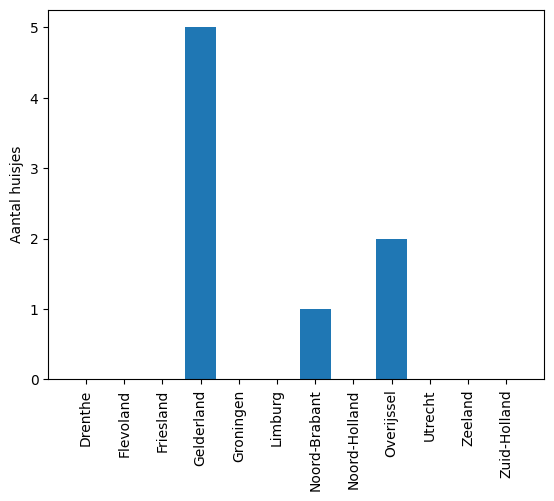

In [41]:
plt.bar(huisjes_voorzieningen_woonplaatsen_provincies['provincie'], huisjes_voorzieningen_woonplaatsen_provincies['aantal_huisjes'])
plt.xticks(rotation=90)
plt.ylabel('Aantal huisjes')
plt.show()

Hier is te zien dat Gelderland de provincie is waar de meeste huisjes staan. Zoals in de eerste fase al beschreven had ik verwacht dat dit Noord-Holland zou zijn. Hierbij zat ik er wel flink naast: Noord-Holland is, ondanks zijn grootte, een van de provincies met het laagst aantal huisjes. Overigens zaten in de dataset geen huurbare huisjes uit Groningen, vandaar dat van deze provincie in dit staafdiagram geen data weergegeven wordt.

<b>Subconclusie:</b> Wat betreft het huisjesaanbod is niet Noord-Holland, maar Gelderland de beste provincie, gevolgd door Overijssel & Noord-Brabant.

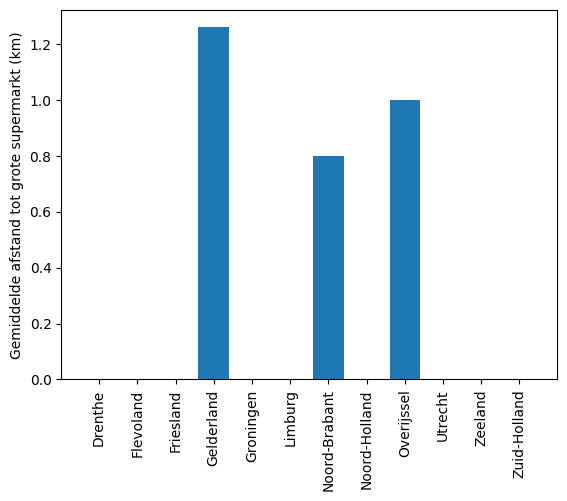

In [42]:
plt.bar(huisjes_voorzieningen_woonplaatsen_provincies['provincie'], huisjes_voorzieningen_woonplaatsen_provincies['gemiddelde_afstand_tot_grote_supermarkt'])
plt.xticks(rotation=90)
plt.ylabel('Gemiddelde afstand tot grote supermarkt (km)')
plt.show()

Waar Gelderland de provincie was met de meeste huisjes zien we hier dat Zuid-Holland als winnaar uit de bus komt wat betreft de bereikbaarheid van supermarkten. Diens staaf is namelijk het laagst, ten teken dat de gemiddelde afstand tot een grote supermarkt per natuurhuisje het kleinst is. Dit is dus in overeenstemming met de eerder gestelde hypothese. Overigens zijn de verschillen tussen provincies wat minder groot dan bij de aantallen huisjes: Zuid-Holland wordt op de voet gevolgd door Utrecht en Friesland.

<b>Subconclusie:</b> Wat de bereikbaarheid van supermarkten betreft is Zuid-Holland, conform de gestelde hypothese, de beste provincie, op de voet gevolgd door Utrecht & Friesland.

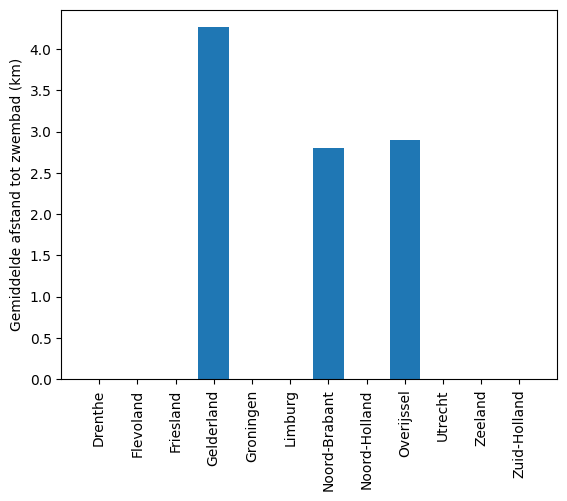

In [43]:
plt.bar(huisjes_voorzieningen_woonplaatsen_provincies['provincie'], huisjes_voorzieningen_woonplaatsen_provincies['gemiddelde_afstand_tot_zwembad'])
plt.xticks(rotation=90)
plt.ylabel('Gemiddelde afstand tot zwembad (km)')
plt.show()

Ten derde blijkt ook hier mijn hypothese ("Zuid-Holland") te kloppen. Drenthe en Zeeland zijn by far de twee provincies met de meest "verre" zwembaden (met 10, respectievelijk 6.7, volgens de interactieve kaart). De rest cirkelt een beetje rond de 4 a 5, met Zuid-Holland als positieve uitschieter (2,6).

<b>Subconclusie:</b> Wat de bereikbaarheid van zwembaden betreft is Zuid-Holland wederom de beste provincie, nipt gevolgd door Noord-Brabant, Gelderland & Friesland.

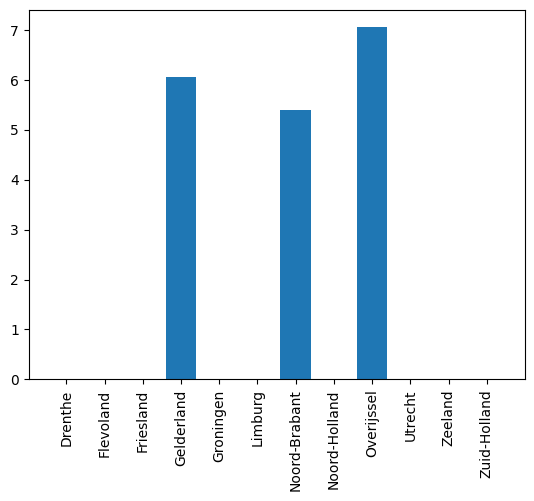

In [44]:
plt.bar(huisjes_voorzieningen_woonplaatsen_provincies['provincie'], huisjes_voorzieningen_woonplaatsen_provincies['gemiddelde_afstand_tot_attractie'])
plt.xticks(rotation=90)
plt.show()

Toch is niet alles rozengeur en maneschijn voor Zuid-Holland, zo blijkt uit deze grafiek. In Friesland en Flevoland is de afstand tot attracties namelijk het laagst, daarna komt Zuid-Holland pas.

<b>Subconclusie:</b> Wat de bereikbaarheid van attracties betreft is niet Zuid-Holland, maar Friesland de beste provincie, met Flevoland op de tweede en Zuid-Holland pas op de derde plek.

## 4c: Beantwoording hoofdvraag en kanttekeningen

Op de vraag: <b>"In welke provincie kan je het beste een huisje huren?"</b> is geen eenduidig antwoord te geven. Gelderland heeft weliswaar de meeste huisjes, maar het is nog maar de vraag of er in die omgeving voldoende te doen is. Deze provincie kwam bij het berekenen van gemiddelde afstanden tot voorzieningen en uitjes namelijk niet als winnaar uit de bus. De meest levendige provincie is, conform verwachting en in zekere mate, Zuid-Holland. De keerzijde hiervan is dat dit de provincie is met een van de minste aangeboden aantallen huisjes. Vooralsnog zou ik op basis van deze analyses iedereen die de rust op wil zoeken en van de mooie Nederlandse natuur wil genieten aanraden naar Gelderland te gaan, terwijl mensen die juist op zoek zijn naar actieve activiteiten meer tot hun recht komen in Zuid-Holland.

2 kanttekeningen bij de uitkomsten van deze analyse en het bovenstaande doorlopen geautomatiseerde proces:
- Het is zeer waarschijnlijk dat bij het doorlopen van het script slechts een deel van de door natuurhuisje.nl aangeboden huisjes wordt ingeladen, aangezien dit een tijdrovend proces is (15 seconden per pagina met zoekresultaten) en gebruikers over het algemeen snelle resultaten willen kunnen zien.
- Ook de huisjes dié ingeladen zijn, zijn niet altijd in de uiteindelijke data-analyses terechtgekomen. Bij het "mergen" van de dataset van natuurhuisje.nl en die van het CBS waren er nogal veel mismatches tussen woonplaatsen. Hierdoor zijn er relatief nogal veel huisjes weggevallen.